# Signal decomposition with Deep Learning
### Author: Javier Gamero Muñoz

**Table of contents**<a id='toc0_'></a>    
- 1. [General libraries](#toc1_)    
- 2. [Load data](#toc2_)    
- 3. [Inputs and outputs of a recurrent NN](#toc3_)    
  - 3.1. [ Using one time serie](#toc3_1_)    
  - 3.2. [Using several time series](#toc3_2_)    
- 4. [Processing data](#toc4_)    
  - 4.1. [Selecting signals](#toc4_1_)    
  - 4.2. [Train and test](#toc4_2_)    
- 5. [Deep learning models](#toc5_)    
  - 5.1. [Models](#toc5_1_)    
    - 5.1.1. [Model: simple LSTM (bidirectional)](#toc5_1_1_)    
    - 5.1.2. [Model: complex LSTM (bidirectional)](#toc5_1_2_)    
    - 5.1.3. [Others techniques](#toc5_1_3_)    
      - 5.1.3.1. [Batch Normalization layers](#toc5_1_3_1_)    
      - 5.1.3.2. [Convolutional layers](#toc5_1_3_2_)    
  - 5.2. [Results comparison](#toc5_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[General libraries](#toc0_)

In [1]:
import os 
import sys 

# path to python main folder in this project
libraries = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) 
sys.path.append(libraries) 

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from time import time

from decompose import quality

# 2. <a id='toc2_'></a>[Load data](#toc0_)

In [2]:
PATH = os.path.abspath(os.path.join(os.getcwd(), (os.pardir+'/')*3)) # main path
PATH

'/Users/javigamero/MyMac/DS_Master/TFM'

In [3]:
t_path = os.path.join(PATH, 'data_preproc/LightSignal_t.csv')
t = pd.read_csv(t_path, sep=';', header=None) # t[0] is nonsensen, remove it
t.set_index(0, inplace=True)

In [4]:
t0 = 150 # (ns), moment to start considering the slow component, EXPERIMENTAL
t_idx = np.where(t>t0)[1] 

In [5]:
t = np.array(t).reshape(-1) #1D array from t0 and on

In [6]:
e_GT_path = os.path.join(PATH, 'data_preproc/LightSignal_decomp_e.csv')
e_signals = pd.read_csv(e_GT_path, sep=';', header=None)
e_signals.set_index(0, inplace=True)

mu_GT_path = os.path.join(PATH, 'data_preproc/LightSignal_decomp_mu.csv')
mu_signals = pd.read_csv(mu_GT_path, sep=';', header=None)
mu_signals.set_index(0, inplace=True)

# total signal: 
signals = mu_signals + e_signals
signals.shape

(20000, 1000)

Functions to create fasts plots:

In [7]:
def plotSignals(t, v, labels, xlabel='Time, t (ns)', ylabel='# photons', sep=False,
                figsize=(5,5)): 
    if len(v)!=len(labels): 
        print('Wrong number of labels')
        return
    
    # in separate plots
    if sep: 
        fig, axs = plt.subplots(1,len(v), figsize=figsize)
        for i in range(len(v)): 
            axs[i].plot(t, v[i], label=labels[i])
            axs[i].set_xlabel(xlabel)
            axs[i].set_ylabel(ylabel) 
            axs[i].legend(loc='best')
            
        plt.tight_layout()
        plt.show()

        return
    
    # all in one figure and plot
    else: 
        plt.figure(figsize=figsize)
        for i in range(len(v)): 
            plt.plot(t, v[i], label=labels[i], alpha=0.75)
            
        plt.xlabel(xlabel)
        plt.ylabel(ylabel) 
        plt.legend(loc='best')
        plt.show()
        
        return
    
# this function will plot the loss results of NN training. It should be used 
# to check if the NN is oferfitting 
def NN_trainPlot(history): 
    fig, ax = plt.subplots(1,1)

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    ax.plot(loss, 'r.', label='Train')
    ax.plot(val_loss, 'b-', label='Validation')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend(loc='best')

    plt.show()

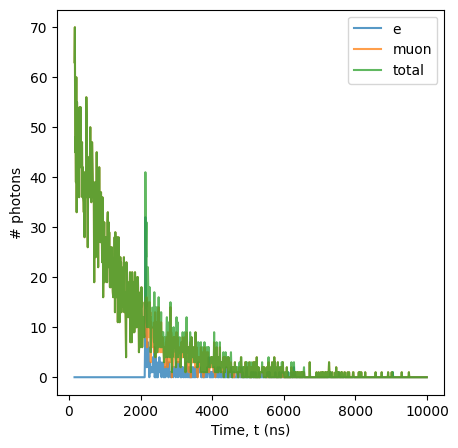

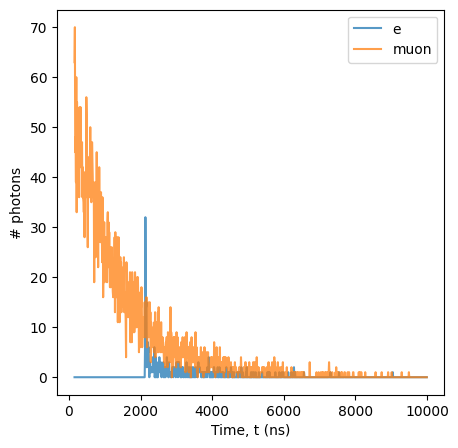

In [8]:
i = 4
e_signal = np.array(e_signals.iloc[i, t_idx]).reshape(-1)
mu_signal = np.array(mu_signals.iloc[i, t_idx]).reshape(-1)
signal = np.array(signals.iloc[i, t_idx]).reshape(-1)

v = [e_signal, mu_signal, signal]
plotSignals(t[t_idx], v, ['e', 'muon', 'total'])

v = [e_signal, mu_signal]
plotSignals(t[t_idx], v, ['e', 'muon'])

# 3. <a id='toc3_'></a>[Inputs and outputs of a recurrent NN](#toc0_)

## 3.1. <a id='toc3_1_'></a>[ Using one time serie](#toc0_)

For instance, let's imagine we have a neural network that only receives one 
time serie for the decomposition.  
In this case, the input dimension of the neural network is one since it only 
receives one array. Also, it only have one neural network to predict another 
array

In [ ]:
from keras import Sequential
from keras.models import Model
from keras.layers import LSTM, Dense

i = 4
a = np.array(e_signals.iloc[i, t_idx]).reshape(-1,1)
b = np.array(mu_signals.iloc[i, t_idx]).reshape(-1,1)
total = np.array(signals.iloc[i, t_idx]).reshape(-1,1)

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, activation = 'sigmoid', input_dim=1))
model.add(Dense(1, activation='linear'))

In [ ]:
total = np.array(signals.iloc[i, t_idx]).reshape(-1,1)
a = np.array(e_signals.iloc[i, t_idx]).reshape(-1,1)
b = np.array(mu_signals.iloc[i, t_idx]).reshape(-1,1)

In [ ]:
np.shape(total)

(985, 1)

Epoch 1/100
28/28 [==============================] - 1s 6ms/step - loss: 2.7585 - val_loss: 0.2122
Epoch 2/100
28/28 [==============================] - 0s 2ms/step - loss: 2.6499 - val_loss: 0.1416
Epoch 3/100
28/28 [==============================] - 0s 2ms/step - loss: 2.5916 - val_loss: 0.0737
Epoch 4/100
28/28 [==============================] - 0s 2ms/step - loss: 2.5619 - val_loss: 0.0613
Epoch 5/100
28/28 [==============================] - 0s 2ms/step - loss: 2.5561 - val_loss: 0.0408
Epoch 6/100
28/28 [==============================] - 0s 2ms/step - loss: 2.5421 - val_loss: 0.0205
Epoch 7/100
28/28 [==============================] - 0s 2ms/step - loss: 2.5388 - val_loss: 0.0215
Epoch 8/100
28/28 [==============================] - 0s 2ms/step - loss: 2.5326 - val_loss: 0.0225
Epoch 9/100
28/28 [==============================] - 0s 2ms/step - loss: 2.5299 - val_loss: 0.0188
Epoch 10/100
28/28 [==============================] - 0s 1ms/step - loss: 2.5281 - val_loss: 0.0147
Epoch 11/

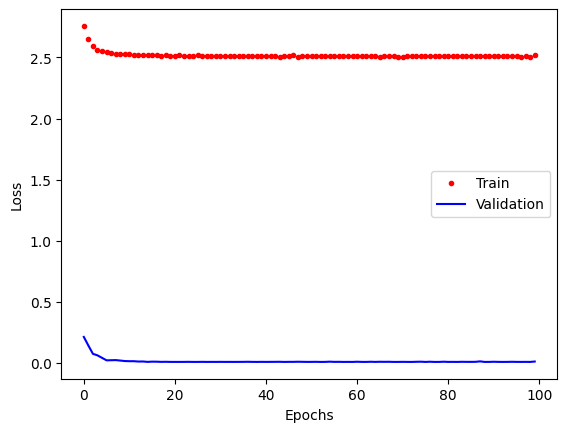

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(total, a, batch_size=32, epochs=100, 
                    validation_split=0.1)

NN_trainPlot(history)

Obviously, the model is too simple to achieve a good result, in fact it is 
overfitting. By the moment, we are just learning what and how to give data to 
the model. 

 1/31 [..............................] - ETA: 0s

31/31 [==============================] - 0s 690us/step


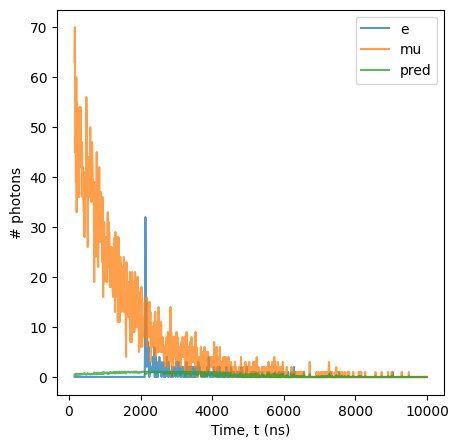

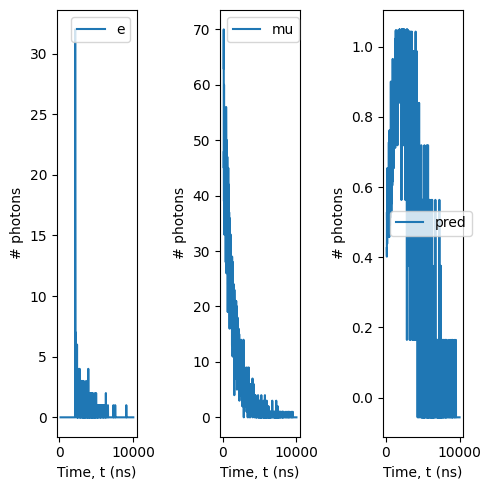

In [ ]:
pred = model.predict(X)

v = [a, b, np.array(pred).reshape(-1,1)]
plotSignals(t[t_idx], v, ['e', 'mu', 'pred'])
plotSignals(t[t_idx], v, ['e', 'mu', 'pred'], sep=True)

Although it seems to predict where the electron is, we go a step further.

## 3.2. <a id='toc3_2_'></a>[Using several time series](#toc0_)

Using one time serie does not generalize a model as much as we would want, and 
we can configure a NN to take all the data to train.  
That is exactly our next step.

We generate the training and test datasets:

In [ ]:
from sklearn.model_selection import train_test_split
X = np.array(signals.iloc[:, t_idx].values) 
y = np.array(e_signals.iloc[:, t_idx].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    random_state=2023)

print(X_train.shape)
print(y_train.shape)

(14000, 985)
(14000, 985)


Due to the usage of LSTM layers, we must configure the shape of the inputs.  
Following the **keras** guide, the input shape of the train dataset must be: 
$$(number\_of\_samples,\ number\_of\_timesteps,\ number\_of\_features).$$

In this moment only have one feature, so we only add a new axis to `X`:

In [ ]:
X_train = X_train[:, :, np.newaxis]

timesteps = int(X_train.shape[1])
features = int(X_train.shape[2])
input_shape = (timesteps,features)

print(input_shape)

(985, 1)


The only thing missing is the **output layer configuration**. We will give a dataset 
X_test to the NN after the training and its output must be one time serie for 
each sample with the same timesteps.  

To achieve it, we will configure the NN with LSTM layers having the parameter 
`return_sequences=True`. This way, the LSTM output is the evaluation at each 
timestep.  
Also, we are configuring one output `Dense` layer with one neuron and linear 
function activation to give the prediction.

Epoch 1/2
307/307 [==============================] - 61s 197ms/step - loss: 2.7044 - val_loss: 2.6793
Epoch 2/2
307/307 [==============================] - 59s 191ms/step - loss: 2.6063 - val_loss: 2.5856


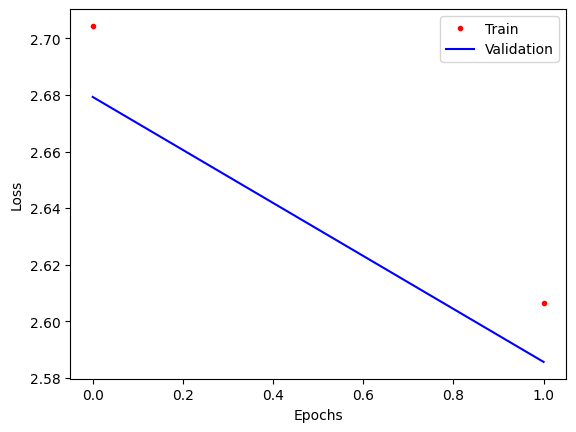

In [ ]:
from keras import Sequential
from keras.layers import LSTM, Dense
from keras.utils import set_random_seed

set_random_seed(2023)
model = Sequential()
model.add(LSTM(units=64, activation = 'sigmoid', return_sequences=True,
               input_shape=input_shape))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=2, 
          validation_split=0.3)

NN_trainPlot(history)

In [ ]:
y_pred = model.predict(X_test[:,:, np.newaxis]) 

188/188 [==============================] - 8s 43ms/step


In [ ]:
np.shape(y_pred)

(6000, 985, 1)

As we can see, the output prediction has the shape we need, 
$$(number\_of\_test\_samples,\ number\_of\_timesteps, 1).$$

Let's check a random prediction:

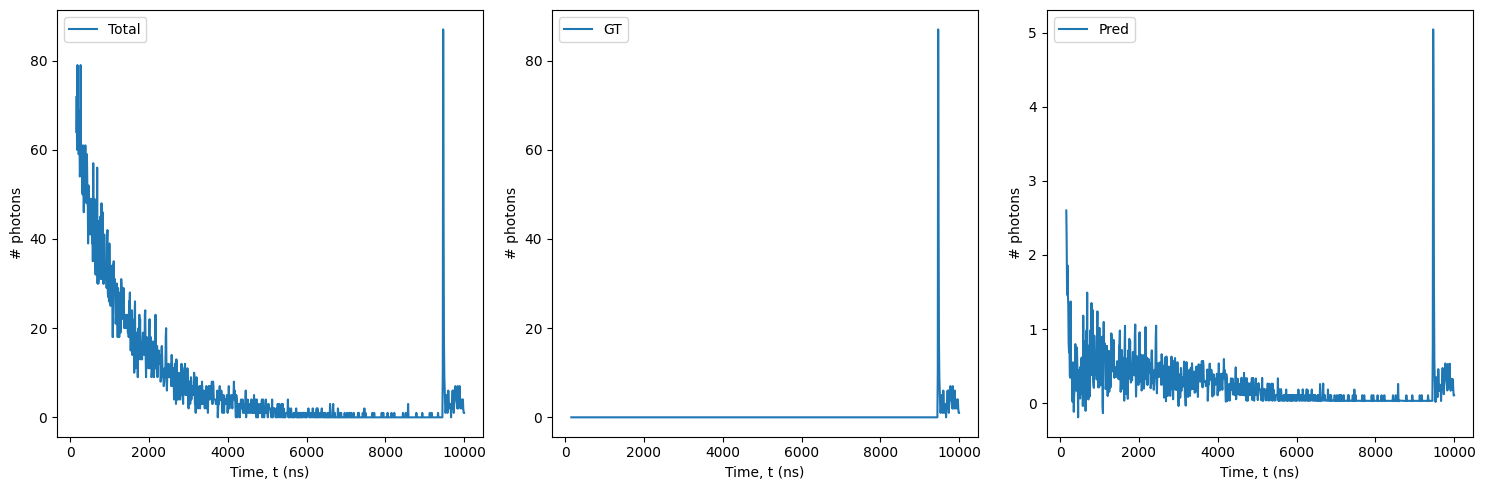

In [ ]:
# y_pred = y_pred[:,:]
i=8
v = [X_test[i,:], y_test[i,:], np.array(y_pred[i,:])]
plotSignals(t[t_idx], v, ['Total', 'GT', 'Pred'], sep='True', figsize=(15,5))

As we can see, this model is too little to reproduce the results, we would need 
a bigger model to improve the signal decomposition.  
**However, we have achieved what we wanted, now, we know how to configure a NN to 
receive our data and produce results.**

# 4. <a id='toc4_'></a>[Processing data](#toc0_)

## 4.1. <a id='toc4_1_'></a>[Selecting signals](#toc0_)

We use some criterias to select the time series where we will try to extract 
the electron.  
- First of all, we take only those signals where the electron has a maximun of at
least `max_p`. This way, we discard those signals where there is no electron and 
where its signal is too low to be detected.
- Second, we set a time `t0` from which the electron must appear to be 
detectable.

In [9]:
max_p = 5 # number of photons
t0 = 150 # ns

In [10]:
criterias = []
for idx in e_signals.index: 
    max_idx = np.argmax(e_signals.loc[idx, :])
    max_peak = np.max(e_signals.loc[idx, :])
    
    if max_peak > max_p and t[max_idx]>t0: 
        criterias.append(idx)

e_signals = e_signals.loc[criterias,:]
signals = signals.loc[criterias,:]
e_signals.shape

(8796, 1000)

## 4.2. <a id='toc4_2_'></a>[Train and test](#toc0_)

Now we create the data to train and test.  

In [11]:
from sklearn.model_selection import train_test_split
X = np.array(signals.iloc[:, t_idx].values) 
y = np.array(e_signals.iloc[:, t_idx].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    random_state=2023)

X_train = X_train[:, :, np.newaxis].astype('float64')
y_train = y_train.astype('float64')

X_test = X_test[:,:, np.newaxis].astype('float64')
y_test = y_test.astype('float64')

In [12]:
print(X_train.shape)
print(X_test.shape)

(6157, 985, 1)
(2639, 985, 1)


In [13]:
timesteps = int(X_train.shape[1])
features = int(X_train.shape[2])
input_shape = (timesteps,features)

print(input_shape)

(985, 1)


# 5. <a id='toc5_'></a>[Deep learning models](#toc0_)

The first thing to know is how we should pass the data to a neural network and 
how to build its output layer. 

## 5.1. <a id='toc5_1_'></a>[Models](#toc0_)

It's time to create bigger models and to use the art state to solve this 
problem.

Function to test a model: 

In [14]:
def testModel(model, history, t, X_test, y_test, plot=True, i=5):

    if history!=None: 
        NN_trainPlot(history)

    y_pred = model.predict(X_test) 
    y_pred = y_pred[:,:,0] # adjust to (n_samples, n_timesteps)

    if plot:
        i=i
        v = [X_test[i,:,0], y_test[i,:], np.array(y_pred[i,:])]
        plotSignals(t, v, ['Total', 'GT', 'Pred'], sep='True', figsize=(15,5))

    e_found = 0
    for GT, pred in zip(y_test, y_pred): 
        q = quality(t, GT, pred)
        if q.isElectronExctracted(): e_found+=1

    print('Ratio e total found: {0}%'.format(e_found / y_test.shape[0] * 100))

### 5.1.1. <a id='toc5_1_1_'></a>[Model: simple LSTM (bidirectional)](#toc0_)

First, we will use a simple bidirectional layer to see if its behaviour:

In [18]:
from keras import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from keras.utils import set_random_seed

def model_SimpleBidirectional(n_hidden_layers=1, n_neurons=[16], 
                              activation=['tanh'], timesteps=985, features=1, 
                              seed=2023):

    set_random_seed(seed)
    
    init = True
    input_shape=(timesteps, features)

    model = Sequential()
    for i in range(n_hidden_layers): 
        if init: 
            # also adds the input layer
            model.add(Bidirectional(LSTM(units = n_neurons[i], 
                                         activation = activation[i], 
                                         return_sequences=True,
                                         input_shape = input_shape
                                         ))) 
            init=False
            
        else: 
            model.add(Bidirectional(LSTM(units = n_neurons[i], 
                                         activation = activation[i], 
                                         return_sequences=True)))
    
    model.add(Dense(1, activation='linear')) # output layer
    
    return model

Epoch 1/10
135/135 [==============================] - 33s 234ms/step - loss: 6.0720 - val_loss: 6.0369
Epoch 2/10
135/135 [==============================] - 40s 294ms/step - loss: 5.7577 - val_loss: 5.6991
Epoch 3/10
135/135 [==============================] - 41s 305ms/step - loss: 5.4008 - val_loss: 5.2923
Epoch 4/10
135/135 [==============================] - 41s 305ms/step - loss: 4.9554 - val_loss: 4.7664
Epoch 5/10
135/135 [==============================] - 41s 303ms/step - loss: 4.3959 - val_loss: 4.2357
Epoch 6/10
135/135 [==============================] - 41s 305ms/step - loss: 3.9598 - val_loss: 3.8537
Epoch 7/10
135/135 [==============================] - 41s 303ms/step - loss: 3.6198 - val_loss: 3.5368
Epoch 8/10
135/135 [==============================] - 42s 311ms/step - loss: 3.3145 - val_loss: 3.3496
Epoch 9/10
135/135 [==============================] - 41s 306ms/step - loss: 3.0650 - val_loss: 2.9526
Epoch 10/10
135/135 [==============================] - 40s 300ms/step - l

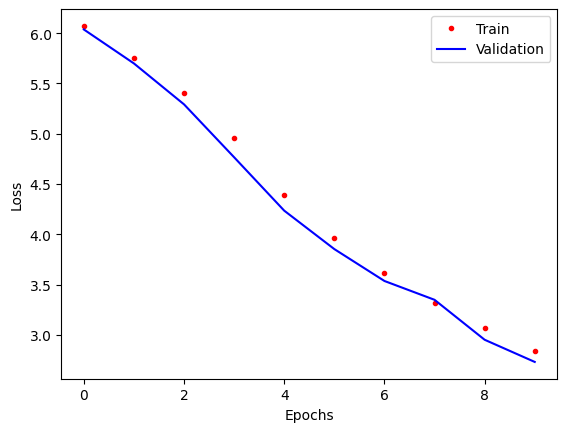

83/83 [==============================] - 5s 59ms/step


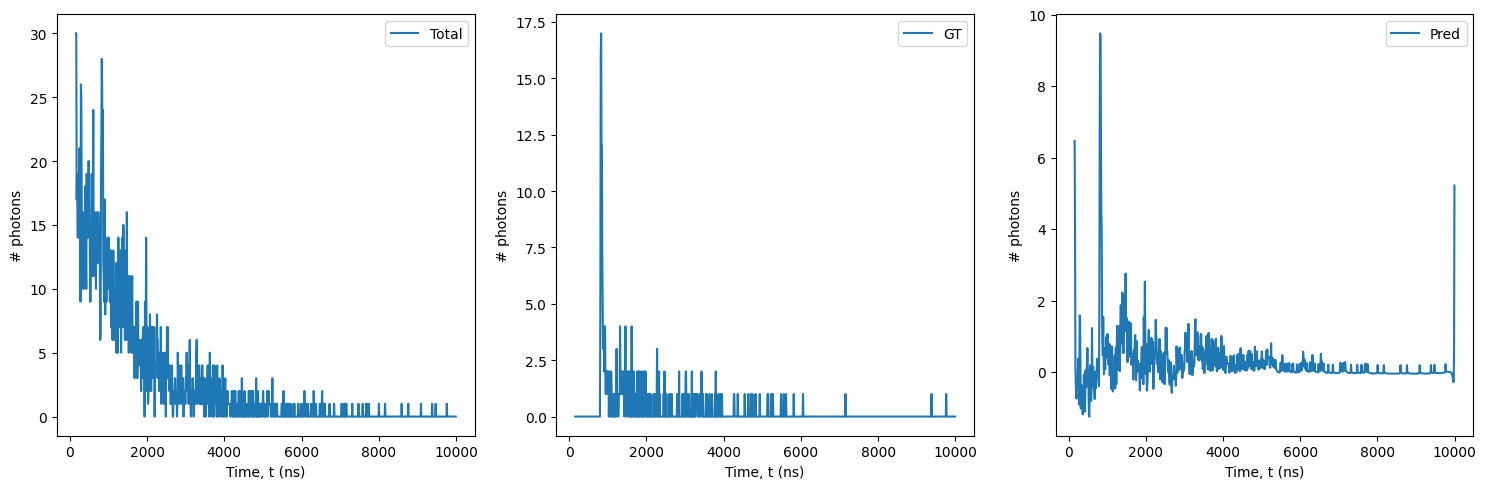

Ratio e total found: 70.40545661235316%


In [19]:
model = model_SimpleBidirectional(n_hidden_layers=1, 
                                  n_neurons=[64], 
                                  activation=['sigmoid'], 
                                  timesteps=timesteps, 
                                  features=features)

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=10, 
                    validation_split=0.3)

testModel(model, history, t[t_idx], X_test, y_test)

To continue, we create this model but changing the activation function in order 
to see if there is another that works better:

Epoch 1/10
135/135 [==============================] - 30s 214ms/step - loss: 5.8958 - val_loss: 5.6592
Epoch 2/10
135/135 [==============================] - 28s 206ms/step - loss: 5.2277 - val_loss: 4.9721
Epoch 3/10
135/135 [==============================] - 27s 199ms/step - loss: 4.5754 - val_loss: 4.3430
Epoch 4/10
135/135 [==============================] - 27s 202ms/step - loss: 3.9553 - val_loss: 3.7513
Epoch 5/10
135/135 [==============================] - 27s 198ms/step - loss: 3.8735 - val_loss: 3.5341
Epoch 6/10
135/135 [==============================] - 27s 201ms/step - loss: 3.1755 - val_loss: 2.9774
Epoch 7/10
135/135 [==============================] - 26s 193ms/step - loss: 2.7457 - val_loss: 2.6207
Epoch 8/10
135/135 [==============================] - 27s 204ms/step - loss: 2.4415 - val_loss: 2.3153
Epoch 9/10
135/135 [==============================] - 27s 199ms/step - loss: 2.1528 - val_loss: 2.0631
Epoch 10/10
135/135 [==============================] - 27s 198ms/step - l

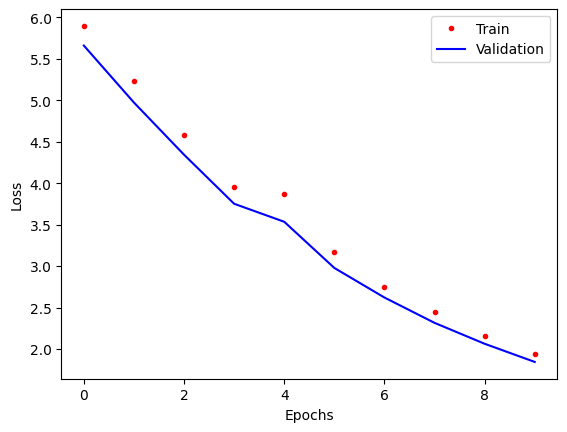

83/83 [==============================] - 4s 44ms/step


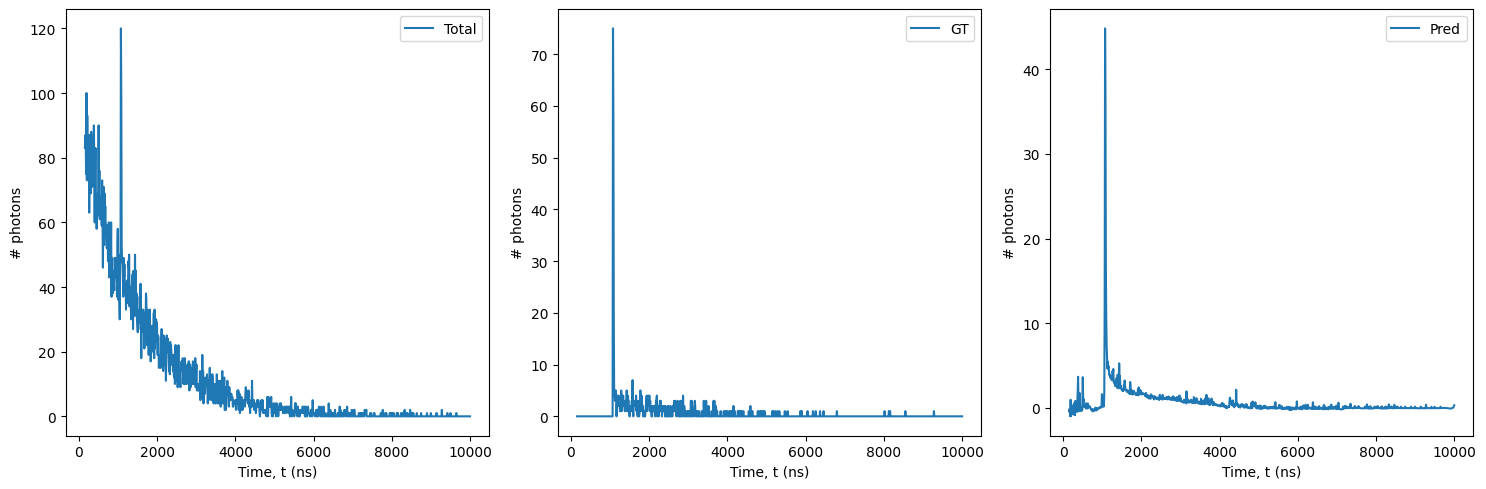

Ratio e total found: 79.80295566502463%


In [21]:
model = model_SimpleBidirectional(n_hidden_layers=1, 
                                  n_neurons=[64], 
                                  activation=['tanh'], 
                                  timesteps=timesteps, 
                                  features=features)

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=10, 
                    validation_split=0.3)

testModel(model, history, t[t_idx], X_test, y_test,i=7)

It seems that the activation `tanh` works better. 
Also, looking at the history plot, we can see that the model could achieve a 
better loss. 

Now, we test another optimizer:

Epoch 1/10
135/135 [==============================] - 29s 204ms/step - loss: 5.8480 - val_loss: 5.7658
Epoch 2/10
135/135 [==============================] - 27s 203ms/step - loss: 5.3385 - val_loss: 5.1591
Epoch 3/10
135/135 [==============================] - 26s 196ms/step - loss: 4.8759 - val_loss: 4.7261
Epoch 4/10
135/135 [==============================] - 26s 196ms/step - loss: 4.4418 - val_loss: 4.6778
Epoch 5/10
135/135 [==============================] - 27s 199ms/step - loss: 4.2495 - val_loss: 3.9639
Epoch 6/10
135/135 [==============================] - 27s 197ms/step - loss: 3.7872 - val_loss: 4.0308
Epoch 7/10
135/135 [==============================] - 26s 194ms/step - loss: 3.5214 - val_loss: 3.3037
Epoch 8/10
135/135 [==============================] - 27s 200ms/step - loss: 3.1469 - val_loss: 3.1522
Epoch 9/10
135/135 [==============================] - 27s 200ms/step - loss: 2.8073 - val_loss: 2.6749
Epoch 10/10
135/135 [==============================] - 26s 194ms/step - l

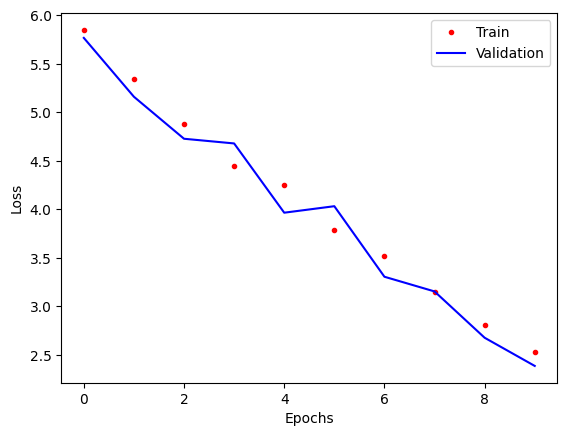

83/83 [==============================] - 4s 44ms/step


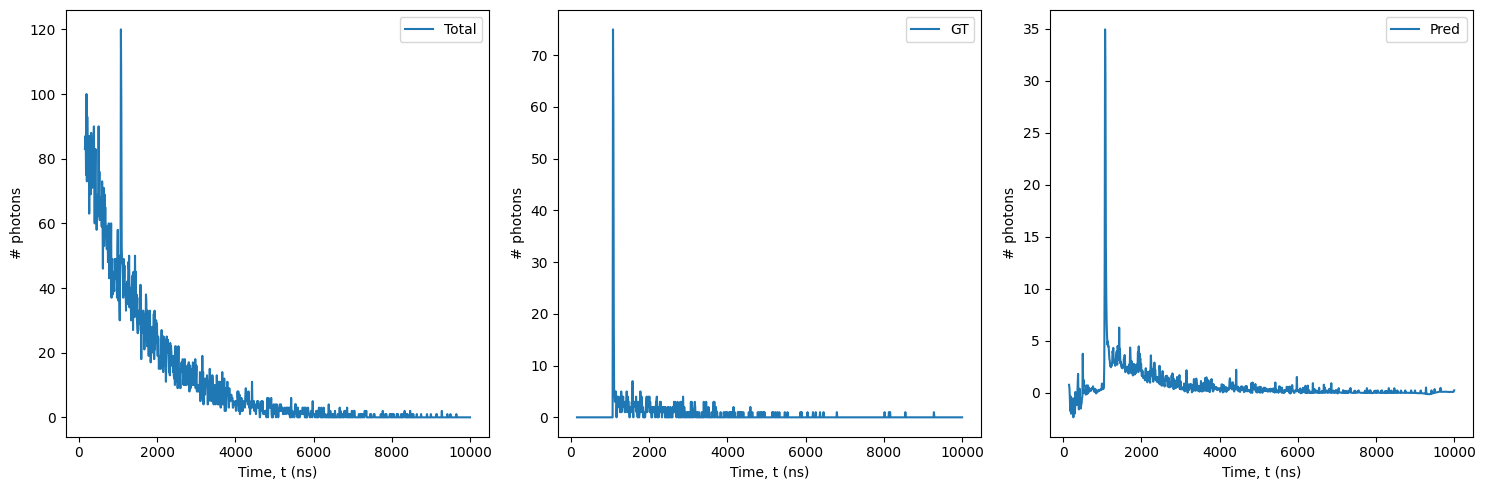

Ratio e total found: 78.51458885941645%


In [22]:
model = model_SimpleBidirectional(n_hidden_layers=1, 
                                  n_neurons=[64], 
                                  activation=['tanh'], 
                                  timesteps=timesteps, 
                                  features=features)

model.compile(optimizer='RMSprop', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=10, 
                    validation_split=0.3)

testModel(model, history, t[t_idx], X_test, y_test,i=7)

Let's test another optimizer: 

Epoch 1/10
135/135 [==============================] - 30s 209ms/step - loss: 6.0631 - val_loss: 6.1470
Epoch 2/10
135/135 [==============================] - 26s 196ms/step - loss: 5.9473 - val_loss: 6.0572
Epoch 3/10
135/135 [==============================] - 27s 201ms/step - loss: 5.8666 - val_loss: 5.9783
Epoch 4/10
135/135 [==============================] - 27s 199ms/step - loss: 5.7765 - val_loss: 5.8190
Epoch 5/10
135/135 [==============================] - 27s 202ms/step - loss: 5.7090 - val_loss: 5.7424
Epoch 6/10
135/135 [==============================] - 27s 203ms/step - loss: 5.6540 - val_loss: 5.6594
Epoch 7/10
135/135 [==============================] - 27s 202ms/step - loss: 5.5780 - val_loss: 5.5811
Epoch 8/10
135/135 [==============================] - 27s 201ms/step - loss: 5.4966 - val_loss: 5.4916
Epoch 9/10
135/135 [==============================] - 26s 195ms/step - loss: 5.4524 - val_loss: 5.5422
Epoch 10/10
135/135 [==============================] - 26s 194ms/step - l

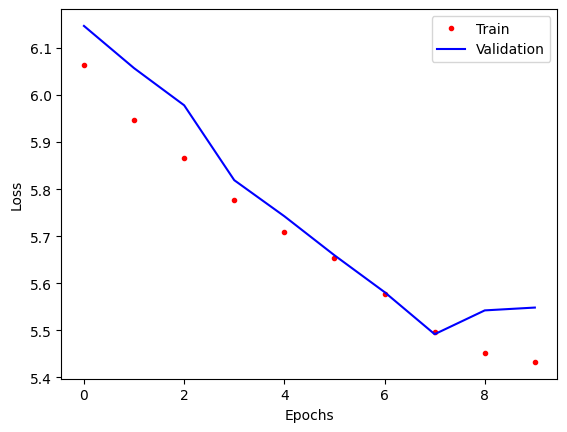

83/83 [==============================] - 4s 45ms/step


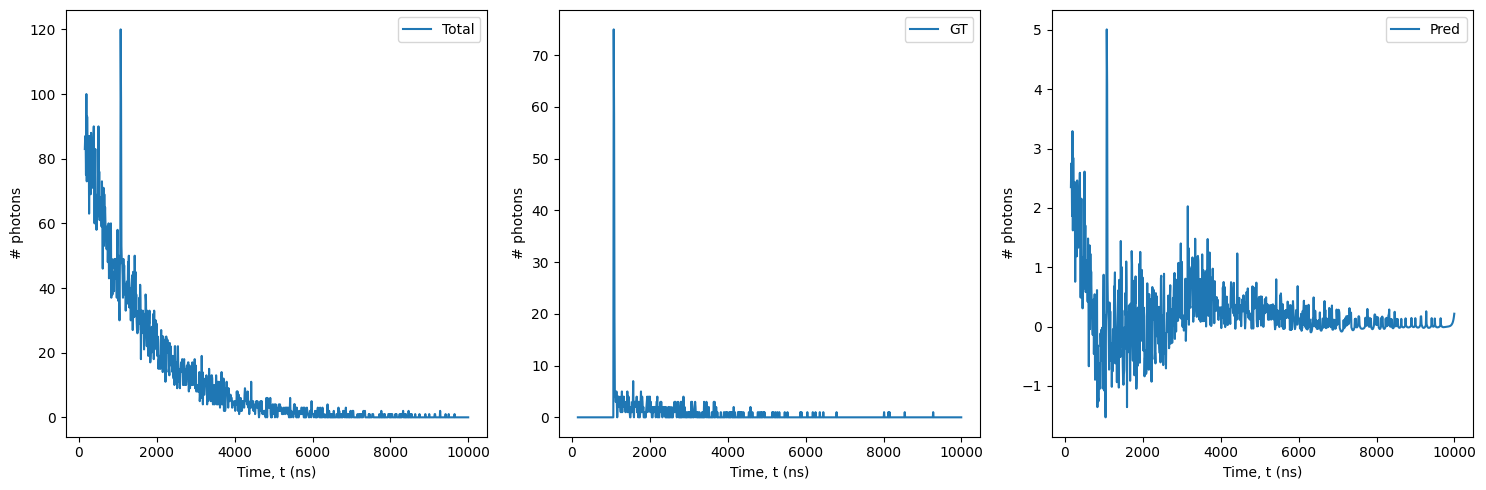

Ratio e total found: 70.78438802576733%


In [23]:
model = model_SimpleBidirectional(n_hidden_layers=1, 
                                  n_neurons=[64], 
                                  activation=['tanh'], 
                                  timesteps=timesteps, 
                                  features=features)

model.compile(optimizer='SGD', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=10, 
                    validation_split=0.3)

testModel(model, history, t[t_idx], X_test, y_test,i=7)

After watching all the results of several executions we create a table to 
compare them: 

<center>

|Model        |e found ratio |MSE
|:-----------:|:------------:|---------|
|64/sigmoid/adam |~70%          |2.70
|64/tanh/adam    |~79%          |1.84
|64/tanh/RMSprop |~78%          |2.30
|64/tanh/SGD     |~70%          |5.5


The best two models are those with the `tanh` function activation and the 
optimization `adam` and `RMSprop`.  
Instead of taking only one of them, we train them again with more epochs. After 
all, the trend pointed out that they could improve more.

Epoch 1/50
135/135 [==============================] - 30s 213ms/step - loss: 5.8958 - val_loss: 5.6592
Epoch 2/50
135/135 [==============================] - 28s 208ms/step - loss: 5.2277 - val_loss: 4.9721
Epoch 3/50
135/135 [==============================] - 28s 207ms/step - loss: 4.5754 - val_loss: 4.3430
Epoch 4/50
135/135 [==============================] - 27s 200ms/step - loss: 3.9553 - val_loss: 3.7513
Epoch 5/50
135/135 [==============================] - 27s 197ms/step - loss: 3.8735 - val_loss: 3.5341
Epoch 6/50
135/135 [==============================] - 27s 200ms/step - loss: 3.1755 - val_loss: 2.9774
Epoch 7/50
135/135 [==============================] - 27s 200ms/step - loss: 2.7457 - val_loss: 2.6207
Epoch 8/50
135/135 [==============================] - 27s 198ms/step - loss: 2.4415 - val_loss: 2.3153
Epoch 9/50
135/135 [==============================] - 27s 198ms/step - loss: 2.1528 - val_loss: 2.0631
Epoch 10/50
135/135 [==============================] - 27s 201ms/step - l

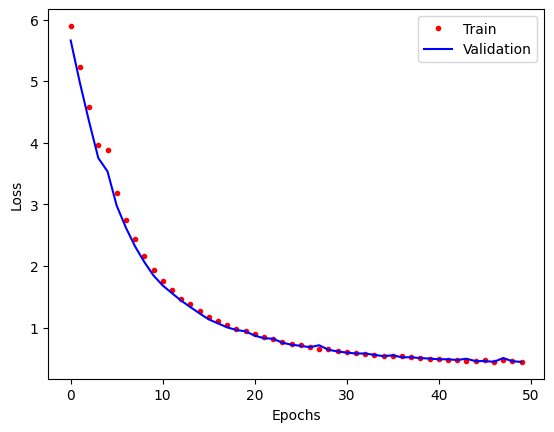

83/83 [==============================] - 4s 44ms/step


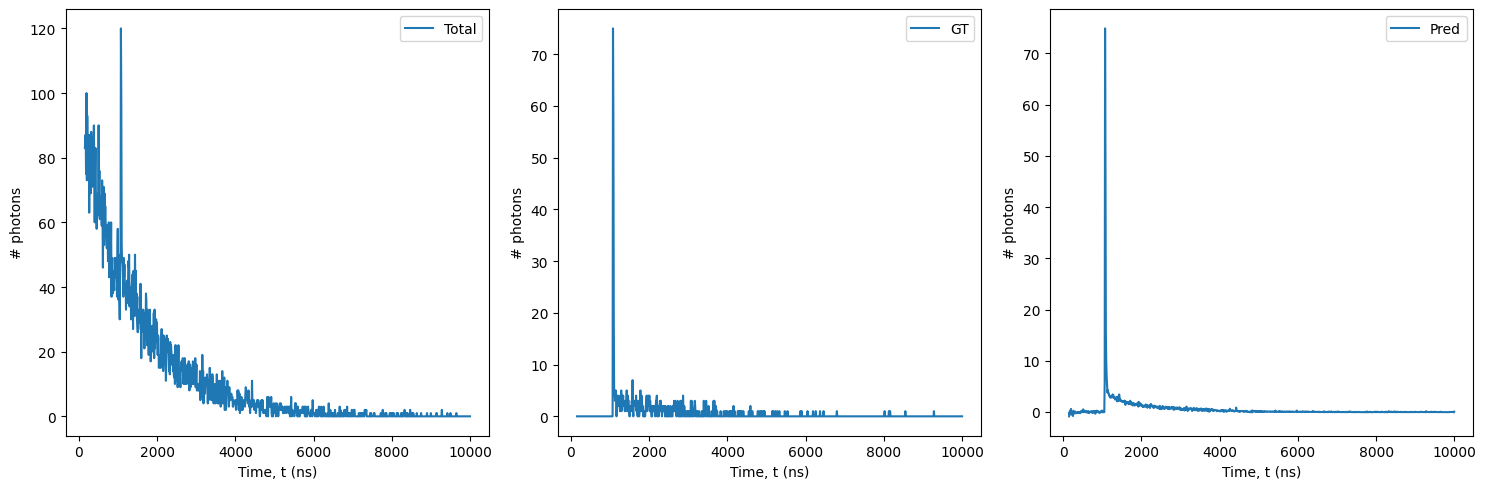

Ratio e total found: 84.53959833270179%


In [24]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True, 
                         mode='auto')

model = model_SimpleBidirectional(n_hidden_layers=1, 
                                  n_neurons=[64], 
                                  activation=['tanh'], 
                                  timesteps=timesteps, 
                                  features=features)

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=50, 
                    validation_split=0.3, callbacks=callback)

testModel(model, history, t[t_idx], X_test, y_test,i=7)

Epoch 1/50
135/135 [==============================] - 28s 194ms/step - loss: 5.8480 - val_loss: 5.7658
Epoch 2/50
135/135 [==============================] - 26s 193ms/step - loss: 5.3385 - val_loss: 5.1591
Epoch 3/50
135/135 [==============================] - 26s 192ms/step - loss: 4.8759 - val_loss: 4.7261
Epoch 4/50
135/135 [==============================] - 26s 195ms/step - loss: 4.4418 - val_loss: 4.6778
Epoch 5/50
135/135 [==============================] - 27s 198ms/step - loss: 4.2495 - val_loss: 3.9639
Epoch 6/50
135/135 [==============================] - 27s 198ms/step - loss: 3.7872 - val_loss: 4.0308
Epoch 7/50
135/135 [==============================] - 26s 196ms/step - loss: 3.5214 - val_loss: 3.3037
Epoch 8/50
135/135 [==============================] - 26s 194ms/step - loss: 3.1469 - val_loss: 3.1522
Epoch 9/50
135/135 [==============================] - 26s 196ms/step - loss: 2.8073 - val_loss: 2.6749
Epoch 10/50
135/135 [==============================] - 27s 197ms/step - l

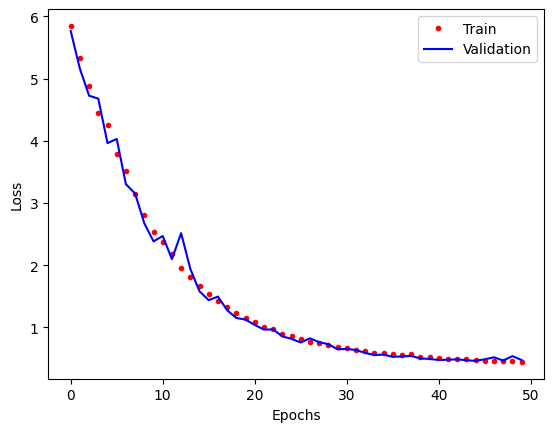

83/83 [==============================] - 4s 45ms/step


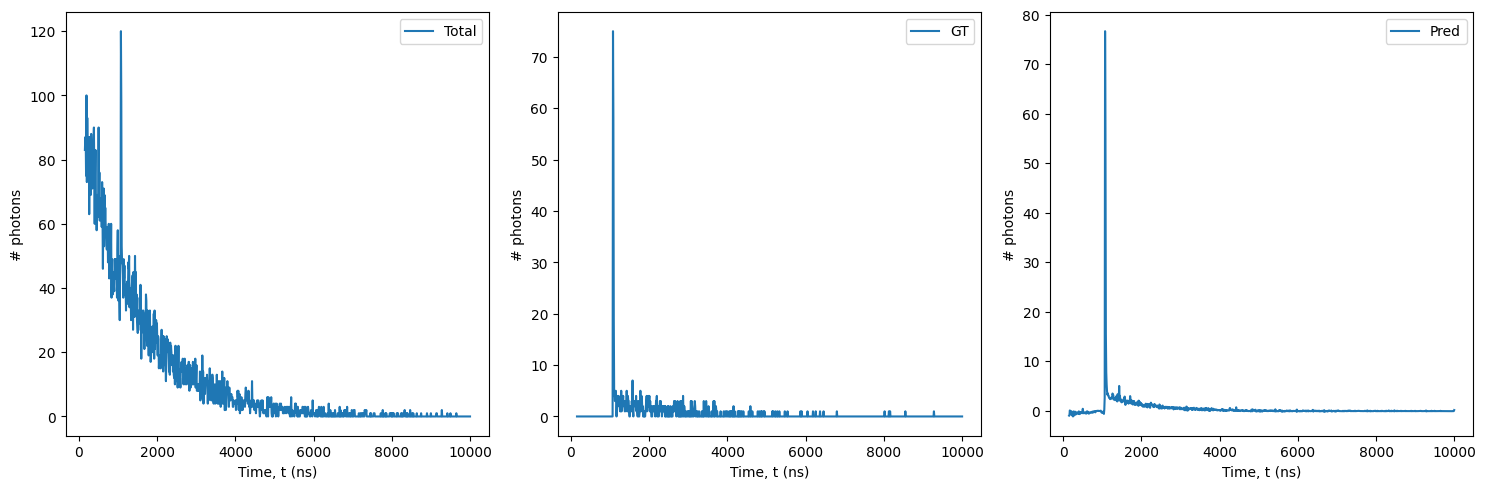

Ratio e total found: 83.28912466843501%


In [25]:
callback = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True, 
                         mode='auto')

model = model_SimpleBidirectional(n_hidden_layers=1, 
                                  n_neurons=[64], 
                                  activation=['tanh'], 
                                  timesteps=timesteps, 
                                  features=features)

model.compile(optimizer='RMSprop', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=50, 
                    validation_split=0.3, callbacks=callback)

testModel(model, history, t[t_idx], X_test, y_test,i=7)

After watching these last results, we conclude that these models cannot improve
the ratio of electron found with more epochs. This training just enhance the 
quality of the signal extracted.  
Updating the previous table: 

<center>

|Model        |e found ratio |MSE
|:-----------:|:------------:|---------|
|64/sigmoid/adam (x10) |~70%          |2.70
|64/tanh/adam (x10)    |~79%          |1.84
|64/tanh/RMSprop (x10) |~73%          |2.30
|64/tanh/SGD  (x10)    |~70%          |5.5
|64/tanh/adam (x50)    |~84%          |0.44
|64/tanh/RMSprop (x50) |~83%          |0.47

In [26]:
MODELS = os.path.join(PATH, os.path.join('scripts', os.path.join('python', 'models')))
model.save(os.path.join(MODELS, 'best_Bidir_LSTM_Simple.keras'), overwrite=True, 
           save_format='tf')

Check it is well saved: 

In [27]:
from keras.saving import load_model

MODELS = os.path.join(PATH, os.path.join('scripts', os.path.join('python', 'models')))
model_test = load_model(os.path.join(MODELS, 'best_Bidir_LSTM_Simple.keras'))

y_pred = model_test.predict(X_test)

83/83 [==============================] - 4s 46ms/step


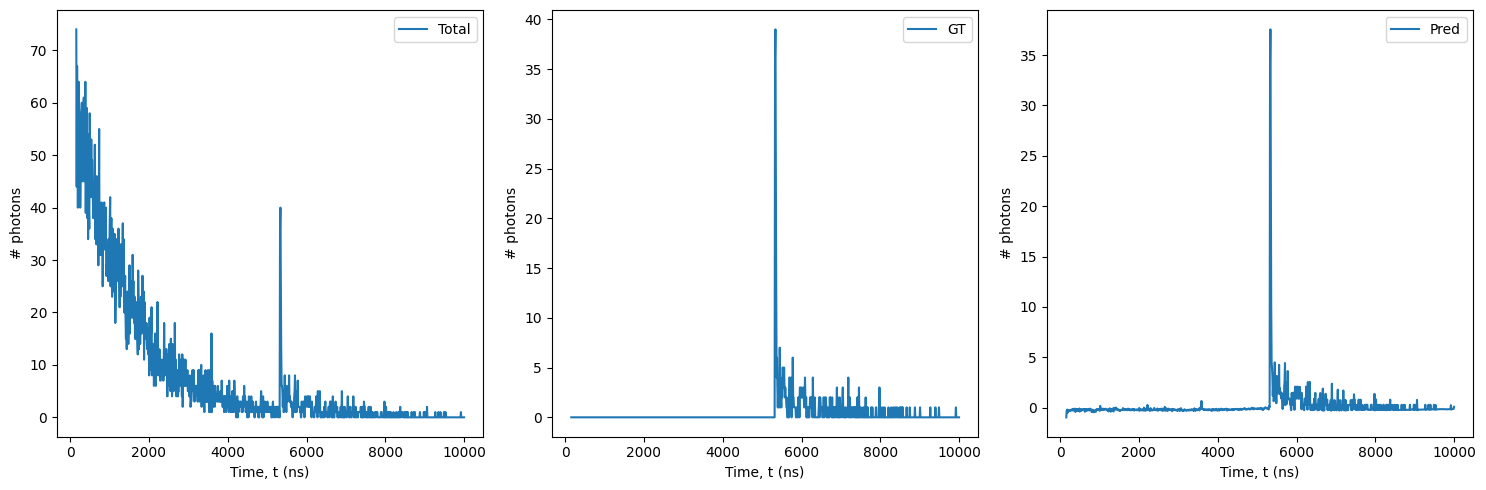

In [31]:
i=8
v = [X_test[i,:,0], y_test[i,:], np.array(y_pred[i,:])]
plotSignals(t[t_idx], v, ['Total', 'GT', 'Pred'], sep='True', figsize=(15,5))

### 5.1.2. <a id='toc5_1_2_'></a>[Model: complex LSTM (bidirectional)](#toc0_)

Now, we add more hidden layers.  
Again, we recreate data:

In [15]:
from keras import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from keras.utils import set_random_seed
from keras.callbacks import EarlyStopping

def LSTMBidirectional(n_hidden_layers=2, n_neurons=[16,16], 
                      activation=['tanh', 'tanh'], timesteps=985, features=1, 
                      seed=2023):

    set_random_seed(seed)
    
    init = True
    input_shape=(timesteps, features)

    model = Sequential()
    for i in range(n_hidden_layers): 
        if init: 
            # also adds the input layer
            model.add(Bidirectional(LSTM(units = n_neurons[i], 
                                         activation = activation[i], 
                                         return_sequences=True,
                                         input_shape = input_shape
                                         ))) 
            init=False
            
        else: 
            model.add(Bidirectional(LSTM(units = n_neurons[i], 
                                         activation = activation[i], 
                                         return_sequences=True)))
    
    model.add(Dense(1, activation='linear')) # output layer
    
    return model

We create models adding more hidden layers with the structure of those that 
won in the simplex model:

Epoch 1/10
135/135 [==============================] - 40s 275ms/step - loss: 6.0906 - val_loss: 6.0511
Epoch 2/10
135/135 [==============================] - 35s 259ms/step - loss: 5.7134 - val_loss: 5.6487
Epoch 3/10
135/135 [==============================] - 35s 261ms/step - loss: 5.3953 - val_loss: 5.4949
Epoch 4/10
135/135 [==============================] - 36s 265ms/step - loss: 5.1128 - val_loss: 5.0421
Epoch 5/10
135/135 [==============================] - 35s 259ms/step - loss: 4.8702 - val_loss: 4.7830
Epoch 6/10
135/135 [==============================] - 35s 260ms/step - loss: 4.6202 - val_loss: 4.5482
Epoch 7/10
135/135 [==============================] - 35s 260ms/step - loss: 4.3945 - val_loss: 5.4965
Epoch 8/10
135/135 [==============================] - 35s 260ms/step - loss: 4.2041 - val_loss: 4.5894
Epoch 9/10
135/135 [==============================] - 35s 259ms/step - loss: 3.9772 - val_loss: 4.5940
Epoch 10/10
135/135 [==============================] - 35s 261ms/step - l

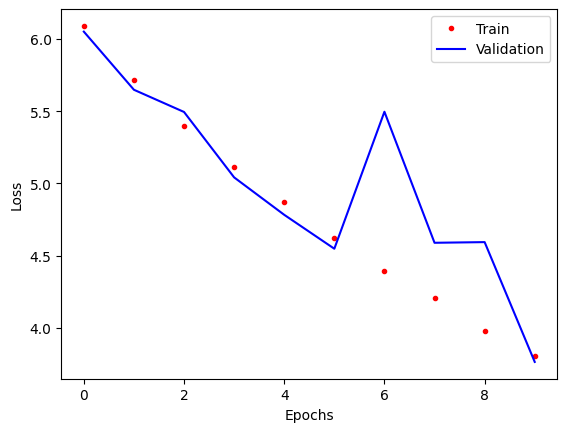

83/83 [==============================] - 4s 44ms/step


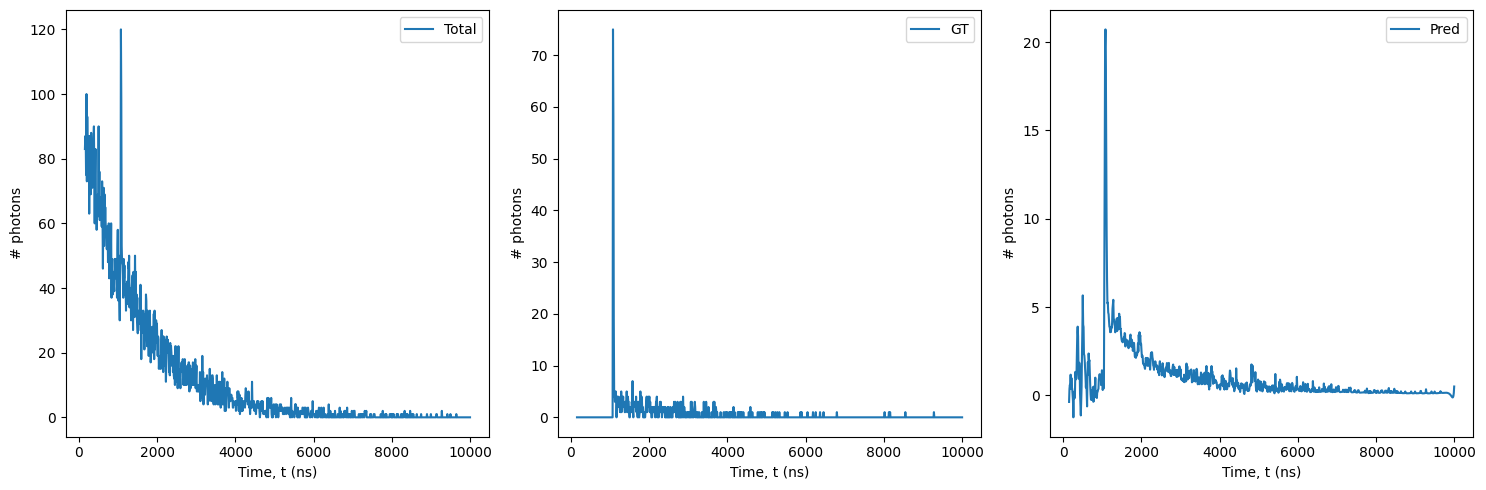

Ratio e total found: 80.06820765441455%


In [16]:
callback = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True, 
                         mode='auto')

model = LSTMBidirectional(n_hidden_layers=2, 
                          n_neurons=[16,16],
                          activation=['tanh', 'tanh'],
                          timesteps=timesteps,
                          features=features)

model.compile(optimizer='RMSprop', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=10, 
                    validation_split=0.3, callbacks=callback)

testModel(model, history, t[t_idx], X_test, y_test, i=7)

Epoch 1/10
135/135 [==============================] - 115s 831ms/step - loss: 5.6082 - val_loss: 4.7962
Epoch 2/10
135/135 [==============================] - 103s 767ms/step - loss: 3.8883 - val_loss: 3.3391
Epoch 3/10
135/135 [==============================] - 99s 733ms/step - loss: 2.8530 - val_loss: 2.4718
Epoch 4/10
135/135 [==============================] - 445s 3s/step - loss: 2.1723 - val_loss: 2.0878
Epoch 5/10
135/135 [==============================] - 106s 788ms/step - loss: 1.6942 - val_loss: 1.5677
Epoch 6/10
135/135 [==============================] - 103s 761ms/step - loss: 1.3558 - val_loss: 1.2283
Epoch 7/10
135/135 [==============================] - 102s 755ms/step - loss: 1.1011 - val_loss: 1.1678
Epoch 8/10
135/135 [==============================] - 100s 738ms/step - loss: 0.9186 - val_loss: 1.0354
Epoch 9/10
135/135 [==============================] - 103s 762ms/step - loss: 0.7827 - val_loss: 0.7055
Epoch 10/10
135/135 [==============================] - 102s 754ms/st

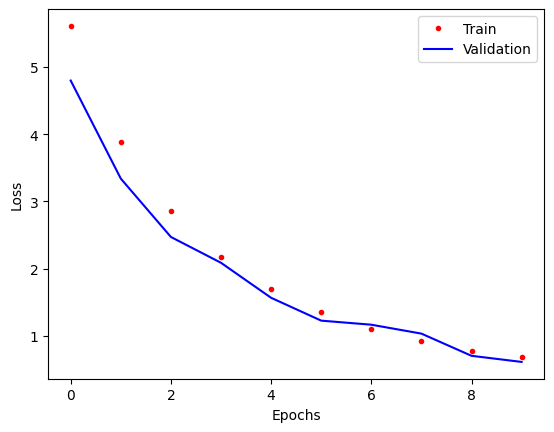

83/83 [==============================] - 14s 164ms/step


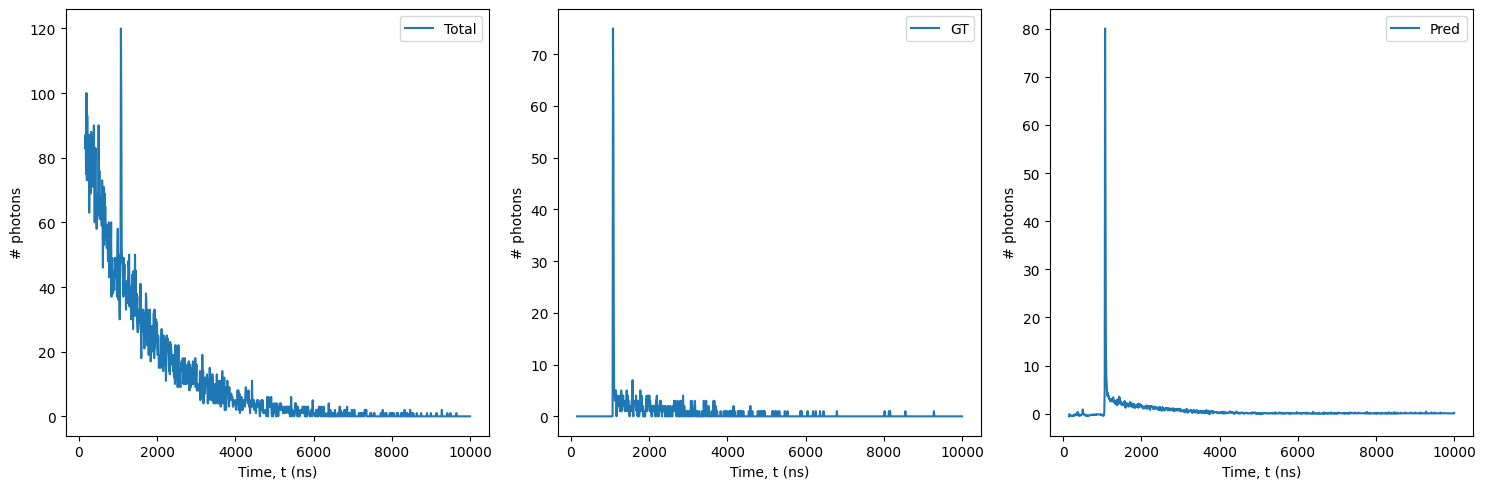

Ratio e total found: 85.41114058355438%


In [17]:
callback = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True, 
                         mode='auto')

model = LSTMBidirectional(n_hidden_layers=2, 
                          n_neurons=[64,64],
                          activation=['tanh', 'tanh'],
                          timesteps=timesteps,
                          features=features)

model.compile(optimizer='RMSprop', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=10, 
                    validation_split=0.3, callbacks=callback)

testModel(model, history, t[t_idx], X_test, y_test, i=7)

In [18]:
MODELS = os.path.join(PATH, os.path.join('scripts', os.path.join('python', 'models')))
model.save(os.path.join(MODELS, '2layers_Bidir_LSTM_Complex.keras'), overwrite=True, 
           save_format='tf')

Epoch 1/10
135/135 [==============================] - 190s 1s/step - loss: 5.3129 - val_loss: 4.0426
Epoch 2/10
135/135 [==============================] - 173s 1s/step - loss: 3.2777 - val_loss: 2.7843
Epoch 3/10
135/135 [==============================] - 182s 1s/step - loss: 2.3231 - val_loss: 1.9602
Epoch 4/10
135/135 [==============================] - 180s 1s/step - loss: 1.7230 - val_loss: 1.4505
Epoch 5/10
135/135 [==============================] - 182s 1s/step - loss: 1.3089 - val_loss: 1.1760
Epoch 6/10
135/135 [==============================] - 177s 1s/step - loss: 1.0279 - val_loss: 0.9075
Epoch 7/10
135/135 [==============================] - 177s 1s/step - loss: 0.8333 - val_loss: 0.7425
Epoch 8/10
135/135 [==============================] - 170s 1s/step - loss: 0.7064 - val_loss: 0.7939
Epoch 9/10
135/135 [==============================] - 181s 1s/step - loss: 0.6077 - val_loss: 0.5947
Epoch 10/10
135/135 [==============================] - 184s 1s/step - loss: 0.5391 - val_lo

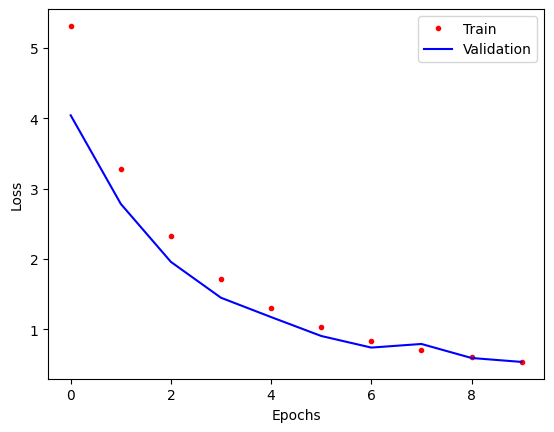

83/83 [==============================] - 24s 277ms/step


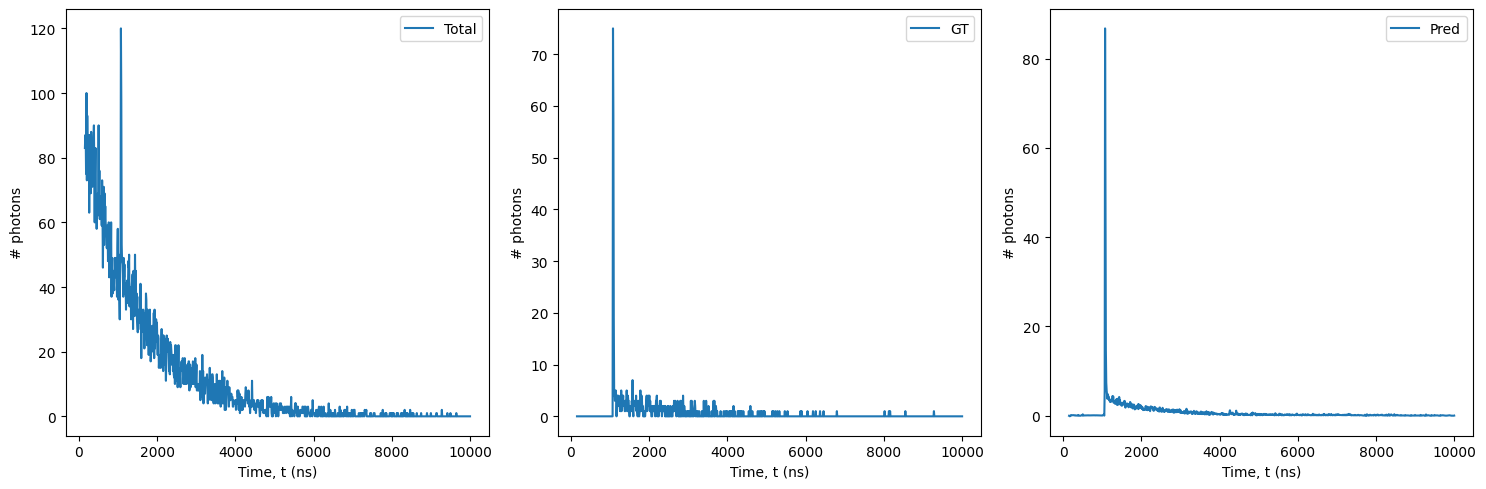

Ratio e total found: 86.20689655172413%


In [19]:
callback = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True, 
                         mode='auto')

model = LSTMBidirectional(n_hidden_layers=3, 
                          n_neurons=[64,64,64],
                          activation=['tanh', 'tanh', 'tanh'],
                          timesteps=timesteps,
                          features=features)

model.compile(optimizer='RMSprop', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=10, 
                    validation_split=0.3, callbacks=callback)

testModel(model, history, t[t_idx], X_test, y_test, i=7)

In [20]:
MODELS = os.path.join(PATH, os.path.join('scripts', os.path.join('python', 'models')))
model.save(os.path.join(MODELS, '3layers_Bidir_LSTM_Complex.keras'), overwrite=True, 
           save_format='tf')

Table to compare results: 

<center>

|Model (neurons/activation/optimizer)  |epochs |e found ratio |MSE
|:-----------------------------|:------:|:------------:|---------|
|[16,16]/[tanh, tanh]/RMSprop  |10     |~80%          |3.7 
|[64,64]/[tanh, tanh]/RMSprop  |10     |~85%          |0.61 
|[64,64,64]/[tanh, tanh, tanh]/RMSprop  |10     |~86%          |0.53

### 5.1.3. <a id='toc5_1_3_'></a>[Others techniques](#toc0_)

#### 5.1.3.1. <a id='toc5_1_3_1_'></a>[Batch Normalization layers](#toc0_)

According to *Ioffe, S. & Szegedy, C.. (2015). Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift*,
the usage of normalization, we include Batch Normalization layers between the 
output of the LSTM layer and the activation function.  
In the paper *Cooijmans, T., Ballas, N. and all. (2017). RECURRENT BATCH NORMALIZATION*, 
there is also a demonstration how useful this approach is.

In [22]:
from keras import Sequential
from keras.layers import LSTM, Dense, Bidirectional, BatchNormalization, Activation
from keras.activations import tanh
from keras.utils import set_random_seed
from keras.callbacks import EarlyStopping

def Add_Block_BN_BiLSTM(model, n_blocks=1, n_neurons=[16], activation = ['tanh'], 
                    input_shape=(985,1)):
    init = True
    
    for i in range(n_blocks):
        if init: 
            model.add(Bidirectional(LSTM(units = n_neurons[i], 
                                         return_sequences=True, 
                                         input_shape = input_shape))) 
            model.add(BatchNormalization())
            model.add(Activation(activation[i]))
            
            init=False
            
        else: 
            model.add(Bidirectional(LSTM(units = n_neurons[i], 
                                         return_sequences=True))) 
            model.add(BatchNormalization())
            model.add(Activation(activation[i]))
                
    return model
        

def BN_Bidir_LSTM(n_blocks=1, n_neurons=[16], activation = ['tanh'], 
                  input_shape=(985,1)):
    set_random_seed(2023)
    
    model = Sequential()
    model = Add_Block_BN_BiLSTM(model, n_blocks, n_neurons, activation, input_shape)
    model.add(Dense(units=1, activation='linear'))
    
    return model

Epoch 1/10
135/135 [==============================] - 22s 146ms/step - loss: 5.8057 - val_loss: 6.1218
Epoch 2/10
135/135 [==============================] - 19s 140ms/step - loss: 5.3359 - val_loss: 6.8603
Epoch 3/10
135/135 [==============================] - 19s 139ms/step - loss: 4.9477 - val_loss: 7.9672
Epoch 4/10
135/135 [==============================] - 19s 140ms/step - loss: 4.6405 - val_loss: 6.9179
Epoch 5/10
135/135 [==============================] - 19s 141ms/step - loss: 4.3767 - val_loss: 5.8297
Epoch 6/10
135/135 [==============================] - 19s 141ms/step - loss: 4.1281 - val_loss: 5.4765
Epoch 7/10
135/135 [==============================] - 19s 141ms/step - loss: 3.8985 - val_loss: 5.3930
Epoch 8/10
135/135 [==============================] - 19s 140ms/step - loss: 3.6901 - val_loss: 4.1755
Epoch 9/10
135/135 [==============================] - 19s 141ms/step - loss: 3.5257 - val_loss: 5.2016
Epoch 10/10
135/135 [==============================] - 19s 141ms/step - l

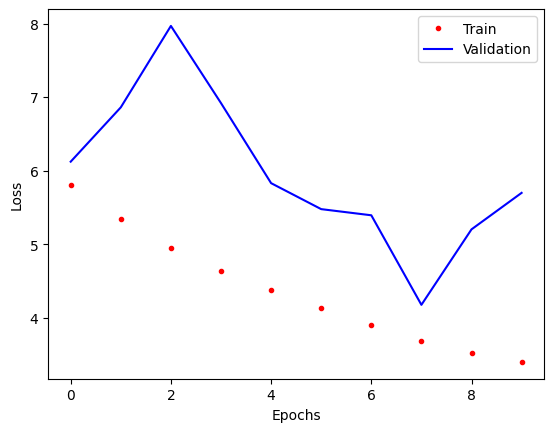

83/83 [==============================] - 3s 29ms/step


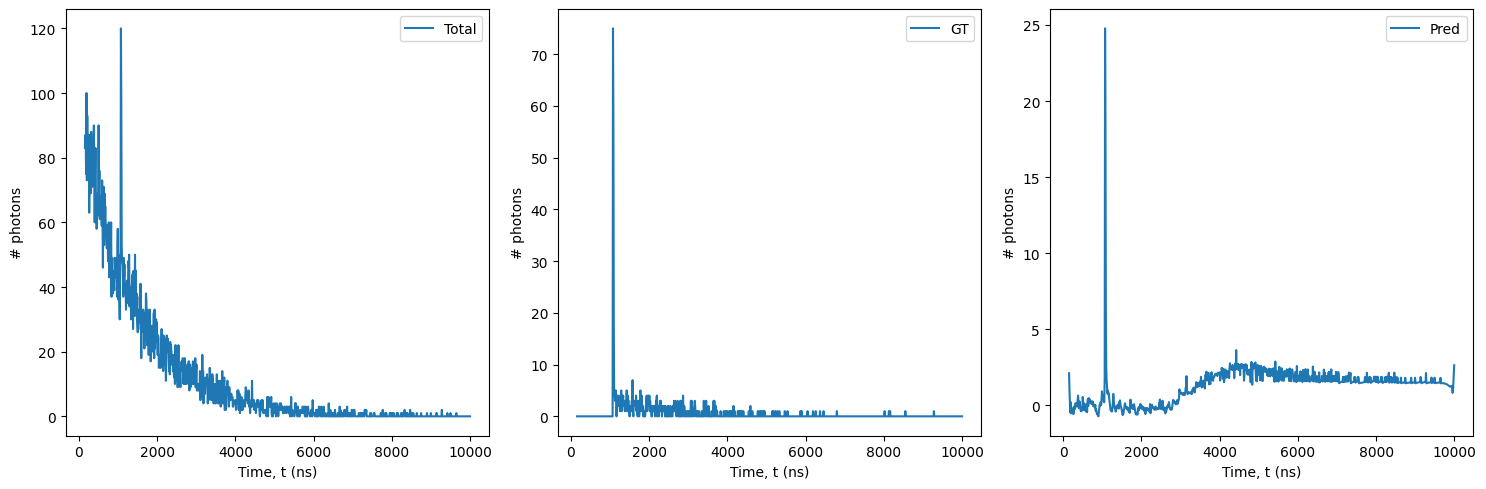

Ratio e total found: 72.67904509283821%


In [24]:
callback = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True, 
                         mode='auto')

model = BN_Bidir_LSTM(n_blocks=1,
                      n_neurons=[32], 
                      activation=['tanh'], 
                      input_shape=input_shape)

model.compile(optimizer='RMSprop', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=10, 
                    validation_split=0.3, callbacks=callback)

testModel(model, history, t[t_idx], X_test, y_test, i=7)

Epoch 1/10
135/135 [==============================] - 114s 826ms/step - loss: 5.3327 - val_loss: 9.6433
Epoch 2/10
135/135 [==============================] - 106s 788ms/step - loss: 4.0557 - val_loss: 5.0038
Epoch 3/10
135/135 [==============================] - 108s 801ms/step - loss: 3.3609 - val_loss: 3.4258
Epoch 4/10
135/135 [==============================] - 107s 795ms/step - loss: 2.9077 - val_loss: 3.1146
Epoch 5/10
135/135 [==============================] - 107s 796ms/step - loss: 2.5592 - val_loss: 2.5021
Epoch 6/10
135/135 [==============================] - 106s 783ms/step - loss: 2.2814 - val_loss: 2.2054
Epoch 7/10
135/135 [==============================] - 107s 794ms/step - loss: 2.0753 - val_loss: 2.0605
Epoch 8/10
135/135 [==============================] - 108s 800ms/step - loss: 1.8896 - val_loss: 1.9981
Epoch 9/10
135/135 [==============================] - 109s 805ms/step - loss: 1.7354 - val_loss: 1.6603
Epoch 10/10
135/135 [==============================] - 107s 796m

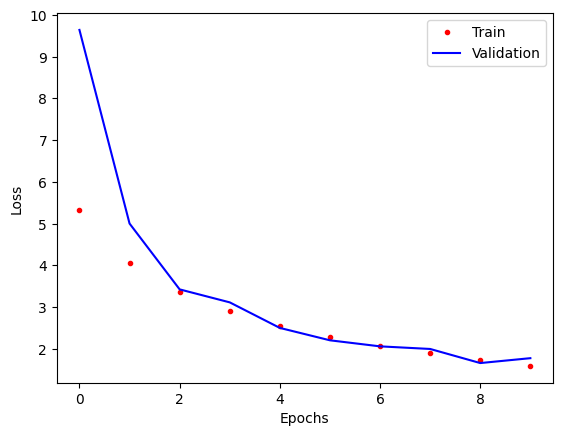

83/83 [==============================] - 14s 162ms/step


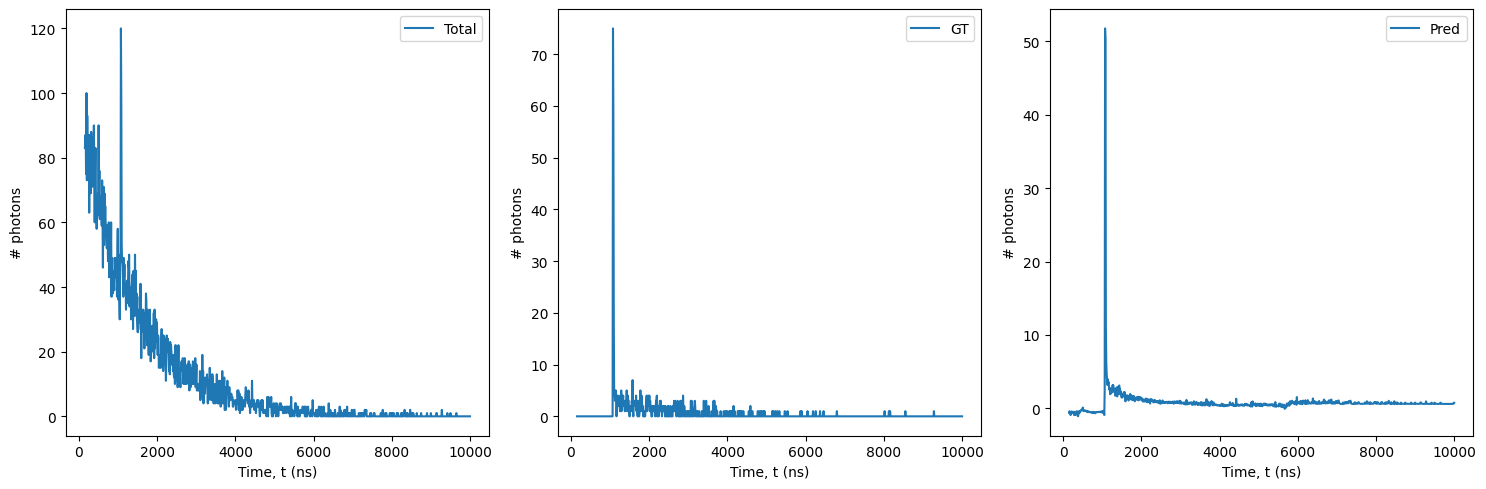

Ratio e total found: 81.5081470253884%


In [26]:
callback = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True, 
                         mode='auto')

model = BN_Bidir_LSTM(n_blocks=2,
                      n_neurons=[64,64], 
                      activation=['tanh', 'tanh'], 
                      input_shape=input_shape)

model.compile(optimizer='RMSprop', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=10, 
                    validation_split=0.3, callbacks=callback)

testModel(model, history, t[t_idx], X_test, y_test, i=7)

In [27]:
from keras.saving import load_model

MODELS = os.path.join(PATH, os.path.join('scripts', os.path.join('python', 'models')))
model.save(os.path.join(MODELS, 'BN_BiLSTM_small.keras'), overwrite=True, 
           save_format='tf')

<center>

|Model (neurons/activation/optimizer)  |epochs |e found ratio |MSE
|:-----------------------------|:------:|:------------:|---------|
|[32]/[BN+tanh]/RMSprop           |10     |~72%          |5.7
|[64,64]/[BN+tanh, BN+tanh]/RMSprop  |10     |~81%          |1.70 


#### 5.1.3.2. <a id='toc5_1_3_2_'></a>[Convolutional layers](#toc0_)

In [30]:
from keras import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Conv1D
from keras.activations import tanh
from keras.utils import set_random_seed
from keras.callbacks import EarlyStopping

set_random_seed(2023)
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=1, padding='same', strides=1, input_shape=input_shape))
model.add(Bidirectional(LSTM(units=32, activation='tanh', return_sequences=True)))
model.add(Dense(units=1, activation='linear'))

In [31]:
callback = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True, 
                         mode='auto')

model.compile(optimizer='RMSprop', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=8, 
                    validation_split=0.3, callbacks=callback)

Epoch 1/8
135/135 [==============================] - 27s 187ms/step - loss: 5.9799 - val_loss: 6.0482
Epoch 2/8
135/135 [==============================] - 25s 186ms/step - loss: 5.8020 - val_loss: 5.8304
Epoch 3/8
135/135 [==============================] - 25s 188ms/step - loss: 5.6631 - val_loss: 5.6886
Epoch 4/8
135/135 [==============================] - 26s 192ms/step - loss: 5.5475 - val_loss: 5.6138
Epoch 5/8
135/135 [==============================] - 25s 188ms/step - loss: 5.4037 - val_loss: 5.3783
Epoch 6/8
135/135 [==============================] - 25s 186ms/step - loss: 5.2572 - val_loss: 5.1561
Epoch 7/8
135/135 [==============================] - 26s 193ms/step - loss: 5.0846 - val_loss: 5.1254
Epoch 8/8
135/135 [==============================] - 26s 190ms/step - loss: 4.9072 - val_loss: 5.1027


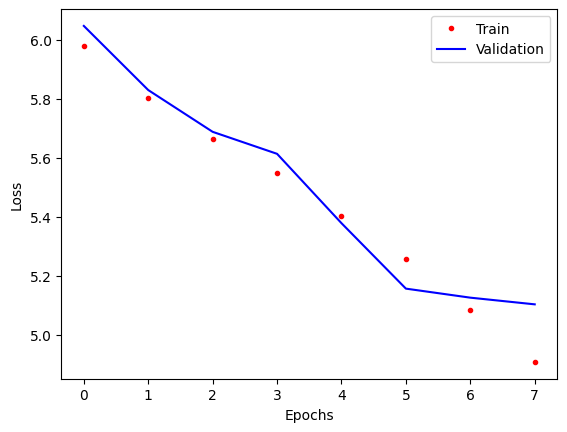

83/83 [==============================] - 3s 33ms/step


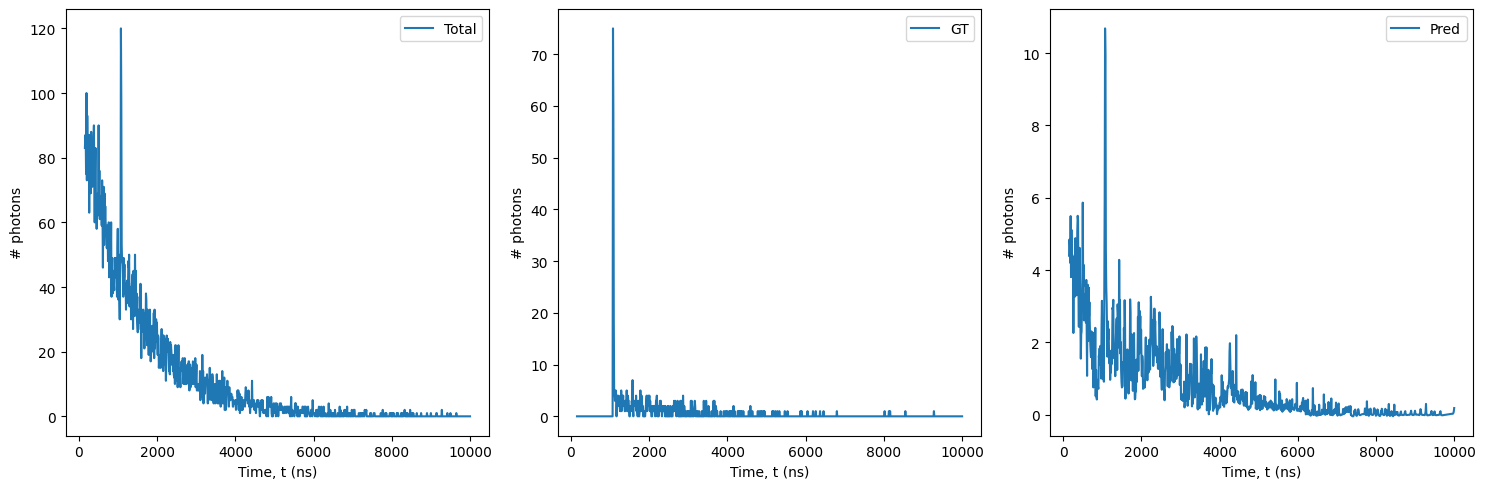

Ratio e total found: 77.45358090185677%


In [32]:
testModel(model, history, t[t_idx], X_test, y_test, i=7)

In [33]:
set_random_seed(2023)

model = Sequential()

model.add(Conv1D(filters=64, kernel_size=1, padding='same', strides=1, input_shape=input_shape))
model.add(Bidirectional(LSTM(units=64, activation='tanh', return_sequences=True)))

model.add(Conv1D(filters=64, kernel_size=1, padding='same', strides=1))
model.add(Bidirectional(LSTM(units=64, activation='tanh', return_sequences=True)))

model.add(Dense(units=1, activation='linear'))

Epoch 1/10
135/135 [==============================] - 85s 609ms/step - loss: 5.5432 - val_loss: 4.5856
Epoch 2/10
135/135 [==============================] - 82s 608ms/step - loss: 3.8894 - val_loss: 3.3462
Epoch 3/10
135/135 [==============================] - 81s 598ms/step - loss: 2.8801 - val_loss: 2.8565
Epoch 4/10
135/135 [==============================] - 78s 581ms/step - loss: 2.2047 - val_loss: 1.8715
Epoch 5/10
135/135 [==============================] - 78s 577ms/step - loss: 1.7492 - val_loss: 1.4368
Epoch 6/10
135/135 [==============================] - 78s 579ms/step - loss: 1.3972 - val_loss: 1.1384
Epoch 7/10
135/135 [==============================] - 80s 593ms/step - loss: 1.1282 - val_loss: 0.9724
Epoch 8/10
135/135 [==============================] - 79s 587ms/step - loss: 0.9529 - val_loss: 0.8201
Epoch 9/10
135/135 [==============================] - 79s 588ms/step - loss: 0.8233 - val_loss: 0.7501
Epoch 10/10
135/135 [==============================] - 79s 587ms/step - l

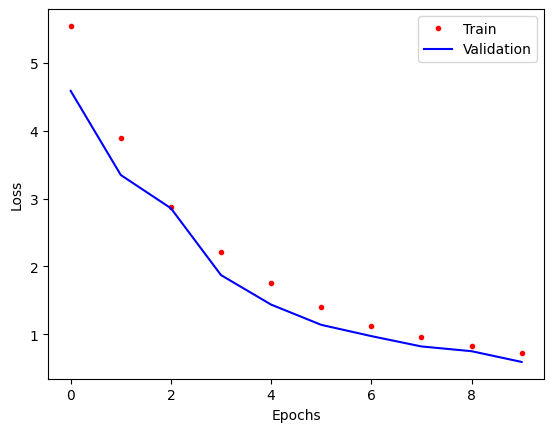

83/83 [==============================] - 11s 121ms/step


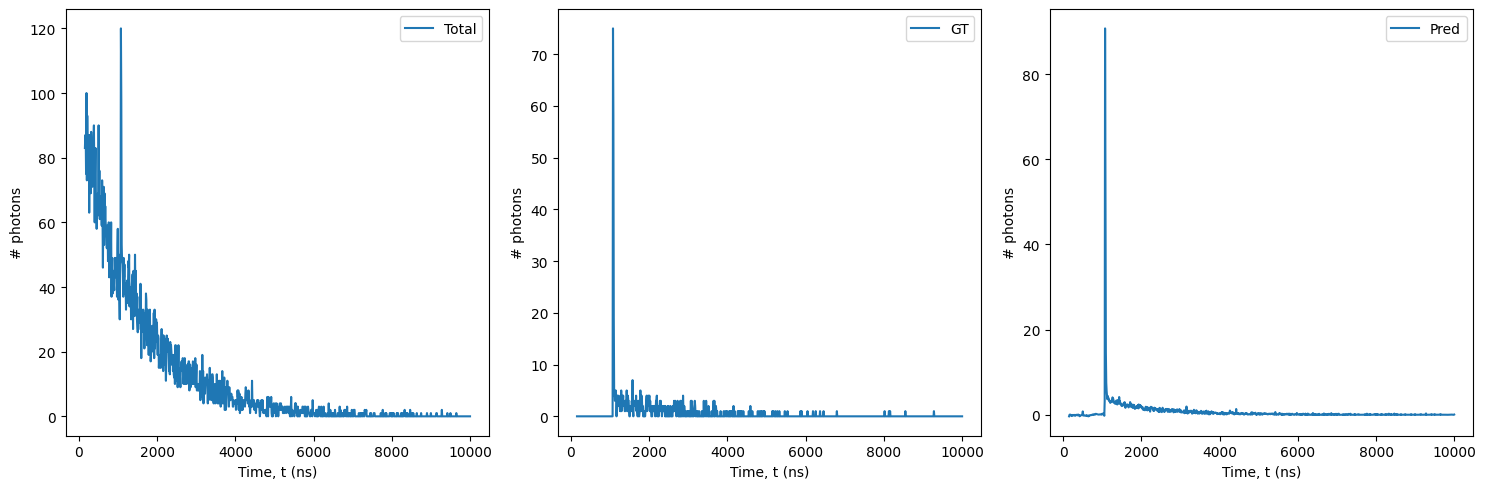

Ratio e total found: 84.19856006062902%


In [34]:
callback = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True, 
                         mode='auto')

model.compile(optimizer='RMSprop', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=10, 
                    validation_split=0.3, callbacks=callback)

testModel(model, history, t[t_idx], X_test, y_test, i=7)

Epoch 1/10
135/135 [==============================] - 125s 896ms/step - loss: 5.4713 - val_loss: 4.3800
Epoch 2/10
135/135 [==============================] - 117s 868ms/step - loss: 3.5491 - val_loss: 3.5315
Epoch 3/10
135/135 [==============================] - 119s 879ms/step - loss: 2.5925 - val_loss: 2.1390
Epoch 4/10
135/135 [==============================] - 117s 870ms/step - loss: 1.9165 - val_loss: 1.5959
Epoch 5/10
135/135 [==============================] - 117s 864ms/step - loss: 1.4714 - val_loss: 1.4367
Epoch 6/10
135/135 [==============================] - 118s 871ms/step - loss: 1.2037 - val_loss: 0.9887
Epoch 7/10
135/135 [==============================] - 124s 921ms/step - loss: 0.9884 - val_loss: 0.8526
Epoch 8/10
135/135 [==============================] - 121s 900ms/step - loss: 0.8425 - val_loss: 0.9137
Epoch 9/10
135/135 [==============================] - 123s 912ms/step - loss: 0.7556 - val_loss: 0.6152
Epoch 10/10
135/135 [==============================] - 119s 883m

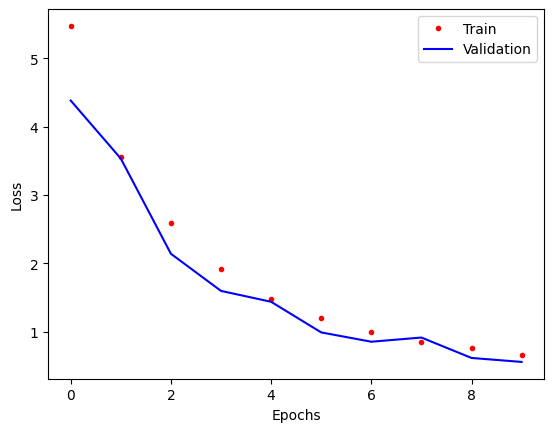

83/83 [==============================] - 16s 183ms/step


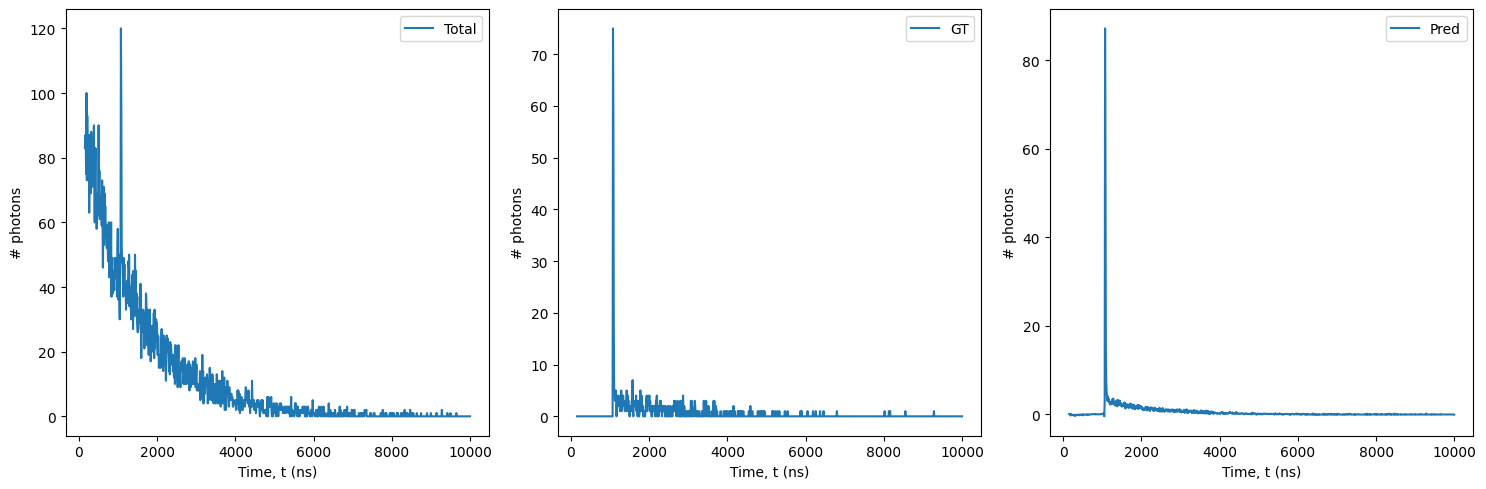

Ratio e total found: 86.01743084501705%


In [36]:
set_random_seed(2023)

model = Sequential()

model.add(Conv1D(filters=64, kernel_size=1, padding='same', strides=1, input_shape=input_shape))
model.add(Bidirectional(LSTM(units=64, activation='tanh', return_sequences=True)))

model.add(Conv1D(filters=64, kernel_size=1, padding='same', strides=1))
model.add(Bidirectional(LSTM(units=64, activation='tanh', return_sequences=True)))

model.add(Conv1D(filters=64, kernel_size=1, padding='same', strides=1))
model.add(Bidirectional(LSTM(units=64, activation='tanh', return_sequences=True)))

model.add(Dense(units=1, activation='linear'))

callback = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True, 
                         mode='auto')

model.compile(optimizer='RMSprop', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=10, 
                    validation_split=0.3, callbacks=callback)

testModel(model, history, t[t_idx], X_test, y_test, i=7)

In [38]:
MODELS = os.path.join(PATH, os.path.join('scripts', os.path.join('python', 'models')))
model.save(os.path.join(MODELS, '3block_ConvBiLSTM_.keras'), overwrite=True, 
           save_format='tf')

<center>

|Model neurons/activation/optimizer  |epochs |e found ratio |MSE
|:-----------------------------|:------:|:------------:|---------|
|[32]/[conv1d+tanh]/RMSprop           |8     |~77%          |5.1
|[64,64]/[conv1D+tanh, conv1D+tanh]/RMSprop  |10     |~84%          | 0.59
|[64,64,64]/[conv1D+tanh, conv1D+tanh, conv1D+tanh]/RMSprop  |10     |~86%          |0.55

## 5.2. <a id='toc5_2_'></a>[Results comparison](#toc0_)

<center>

|Model (neurons/activation/optimizer)  |epochs  |e found ratio  |MSE
|:-------------------------------------:|:------:|:--------------|:----
|64/sigmoid/adam                        |10      |~70%           |2.70
|64/tanh/adam                           |10      |~79%           |1.84
|64/tanh/RMSprop                        |10      |~73%           |2.30
|64/tanh/SGD                            |10      |~70%           |5.50
|64/tanh/adam                           |50      |~84%           |0.44
|64/tanh/RMSprop                        |50      |~83%           |0.47
|[16,16]/[tanh, tanh]/RMSprop           |10      |~80%           |3.70
|[64,64]/[tanh, tanh]/RMSprop           |10      |~85%           |0.61 
|[64,64,64]/[tanh, tanh, tanh]/RMSprop  |10      |**~86%**           |0.53
|[32]/[BN+tanh]/RMSprop                 |10      |~72%           |5.70
|[64,64]/[BN+tanh, BN+tanh]/RMSprop     |10      |~81%           |1.70 
|[32]/[conv1d+tanh]/RMSprop             |8       |~77%           |5.10
|[64,64]/[conv1D+tanh, conv1D+tanh]/RMSprop  |10 |~84%           |0.59
|[64,64, 64]/[conv1D+tanh, conv1D+tanh, conv1D+tanh]/RMSprop  |10     |**~86%**          | 0.55